# Assignment 2

## Formalia:

Please read the [assignment overview page](https://github.com/suneman/socialdata2022/wiki/Assignment-1-and-2) carefully before proceeding. This page contains information about formatting (including formats etc.), group sizes, and many other aspects of handing in the assignment. 

_If you fail to follow these simple instructions, it will negatively impact your grade!_

**Due date and time**: The assignment is due on Monday, March the 28th, 2022 at 23:59. Hand in your files via [http://peergrade.io](http://peergrade.io/).

**Peergrading date and time**: _Remember that after handing in you have 1 week to evaluate a few assignments written by other members of the class_. Thus, the peer evaluations are due on Monday, April the 4th, 2022 at 23:59.

**Contributions**: In class I told you we will use DTU Learn. But Sune came up with a nicer idea!! **I'll send you a secret id by email later today** so you can add the contributions directly at the end of the notebook. They should look somewhat like this:

* id1: did this, this, and this
* id2: did that, that, and that
* id3: ...

**N.B.** It is NOT OK to say that each member contributed equally!

This Assignment is based on the last three weeks of the course (Week 6-8). Before going on please load the data with the following line. In this way, you won't need to submit anything else than the .ipynb file and we will be able to run your notebook!

In [109]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import bokeh.plotting as bp
import matplotlib.lines as mlines
import warnings

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn import tree
from bokeh.models import HoverTool
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, Legend

In [37]:
column_list = ["age", "sex", "race", "juv_fel_count", "juv_misd_count", "juv_other_count",
               "priors_count", "two_year_recid", "days_b_screening_arrest"]

warnings.filterwarnings("ignore")

df = pd.read_csv("https://raw.githubusercontent.com/suneman/socialdata2022/main/files/recidivism_dataset_sub.csv", usecols=column_list)

## Part 1: Predicting criminal recidivism

The following exercises are a subset of the ones we did during Week 6. If you have doubts or need more help, go back to the Week 6 notebook. There, you will find additional hints to complete the assignment.

> *Exercise 1:* Build a Decision Tree or a Random Forest. 
>   * Preprocess the data by only keeping records that have between $-30$ and $30$ days between the arrest and screening, then drop the `days_b_screening_arrest` column for the upcoming analysis.
>   * Some features we are working with are categorical, so we need to deal with them by using encoders. There are many different types, but we will focus on the `OneHotEncoder` and the `LabelEncoder`:
>      * Which encoder did you choose? Describe what it does and why you chose it.
>   * Split the data in Train/Test sets by using a 70/30 split and `random_state=42`.
>   * Fit a model to your Train set. Choose between a `DecisionTreeClassifier` or a `RandomForestClassifier`. 
>      * Describe how the model you chose works and why you chose it.
>   * Evaluate the performance of model on the test set, i.e compute Accuracy, Precision, and Recall. 
>      * What are your thoughts on these metrics? Is accuracy a good measure?
>   * Are your results tied to the specific hyperparameter set you used? Perform a `RandomizedSearchCV` and recompute the performance metric above with the hyperparameters found. What do you observe?
>   * Visualize the tree. There are different options to do so. You can have a look at Week 6 for hints on how to do it. What do you observe?

## Part 1: Solution

In [38]:
features = ["age", "sex", "race", "juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count"]
target = "two_year_recid"

filtered = df[abs(df.days_b_screening_arrest) <= 30].drop('days_b_screening_arrest', axis=1)

> When using label encoding the `race` column is going to be ranked based on the alphabetical order of the original values. This is dangerous because the model might capture a hierarchy between the values while in reality they aren't really ordinal variables. To avoid this we are using the One-Hot encoding. Even though One-Hot encoding can lead to a problem where the variables are highly correlated to each other, we will stick to it, and handle the issue of multicolinearity later on. We are encoding `race` and `sex`.

In [39]:
encoder = OneHotEncoder(handle_unknown='ignore')

# encoding race
fit_race = encoder.fit_transform(filtered.race.values.reshape(-1,1)).toarray()
race_encoded = pd.DataFrame(fit_race, columns=["race_" + str(i + 1) for i in range(fit_race.shape[1])])
X = pd.concat([filtered, race_encoded], axis=1).drop('race', axis=1)

# encoding sex
fit_sex = encoder.fit_transform(filtered.sex.values.reshape(-1,1)).toarray()
sex_encoded = pd.DataFrame(fit_sex, columns=["is_female", "is_male"])
X = pd.concat([X, sex_encoded], axis=1).drop(["sex", "is_female"], axis=1)

X.dropna(inplace=True)

> Since the encoded sex columns are trivially correlated, we are dropping one of them. But things aren't so for the encoded race columns. One of the things we can do there is calculate Variance Inflation Factor (VIF) which tells us how much molticollinearity the columns present. If VIF > 5 then we need to drop some of the columns. REF1

In [40]:
vif_df = pd.DataFrame(columns = ['Var', 'Vif'])
x_var_names = race_encoded.columns

for i in range(0, x_var_names.shape[0]):
    y = race_encoded[x_var_names[i]]
    x = race_encoded[x_var_names.drop([x_var_names[i]])]
    r_squared = sm.OLS(y,x).fit().rsquared
    vif = round(1/(1-r_squared),2)
    vif_df.loc[i] = [x_var_names[i], vif]

vif_df

,Var,Vif
0,race_1,1.0
1,race_2,1.0
2,race_3,1.0
3,race_4,1.0
4,race_5,1.0
5,race_6,1.0


> Since VIF = 1 for all of the columns, there isn't an issue with multicollinearity, so we can proceed without dropping any of the columns. The exercise didn't specify the target, so we are sticking to the original one mentioned in Week 6, which is `two_year_recid`

In [41]:
y = X['two_year_recid']
X.drop('two_year_recid', axis=1, inplace=True)

# splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

> Our choice of classification model landed upon the `RandomForestClassifier` as it tends to yield better results on datasets than simple decision trees. This is simply due to the fact that it uses more trees. The only drawback is the amount of computation necessary to use the method, but since the dataset is rather small, we can overlook this fact.

> To understand what a random forest is, first we have to understand what a decision tree is. A decision tree is a supervised learning method that can be used to solve classification (and regression) tasks. The way it solves the problem is by learning simple decision rules from the data features. Decision rules are as simple as asking whether a number is greater or lower than 1. The difficult question is which questions to ask, and the best question is the one that separates the data best. This can be measured using different techniques like entropy or impurity gain. A random forest takes decision trees as its building blocks constructs them and draws conclusions by interpreting the individual results and putting the together by majority voting (or taking the average if it is a regression task). The term "random" in random forests means that each decision tree in the forest considers a random subset of the features when formulating the questions and can only access a random set of the training data, thus increasing diversity and lowering the chance of overfitting. REF2&3

In [42]:
classifier = RandomForestClassifier(n_estimators = 1000, random_state = 42)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
errors = abs(y_pred - y_test)
error_rate = len(errors[errors == 1]) / len(y_pred)
print('Error rate: ' + str(error_rate))

Error rate: 0.3619167717528373


> The baseline for error rate metric could be set to 50% in binary classification problems with no prior background knowledge, as that is the percentage of classes you will get right if you guess randomly on a balanced dataset in terms of labels. As we can see the error rate for our model is around 36% percent so the accuracy is 64%. One might think that having high accuracy is good, but this metric is heavily influenced by the unbalancedness of a dataset in terms of classes we want to predict. In our case it's slightly tilted to the not recid class:

In [43]:
print('Not recid:' + str(len(y[y == 0])))
print('Recid:' + str(len(y[y == 1])))

Not recid:2888
Recid:2398


>If we want a more clear picture, we also have to observe other metrics, such as precision, recall, f1 score...

In [44]:
print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))
print('Precision: ' + str(precision_score(y_test, y_pred)))
print('Recall: ' + str(recall_score(y_test, y_pred)))
print('F1 score: ' + str(f1_score(y_test, y_pred)))

Accuracy: 0.6380832282471627
Precision: 0.5962373371924746
Recall: 0.5827439886845828
F1 score: 0.5894134477825465


> We can now see that our model performed slightly better than the baseline. We could improve the model by using leave-one-out cross validation, or `RandomizedSearchCV`, to tune our hyperparameters. REF4

In [45]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

classifier_random = RandomizedSearchCV(estimator=classifier, param_distributions=random_grid, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
classifier_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(n_estimators=1000,
                                                    random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

> And now we can evaluate the performance of our model again, and observe that while the accuracy hasn't really improved all that well, the precision got better but the recall got worse, and it all adds up to the overall f1 score to be 1% better. Hyperparameter tuning seems to have had a minor improvment effect overall.

In [46]:
y_pred = classifier_random.predict(X_test)

print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))
print('Precision: ' + str(precision_score(y_test, y_pred)))
print('Recall: ' + str(recall_score(y_test, y_pred)))
print('F1 score: ' + str(f1_score(y_test, y_pred)))

Accuracy: 0.667717528373266
Precision: 0.6446945337620579
Recall: 0.5671852899575672
F1 score: 0.6034612490594432


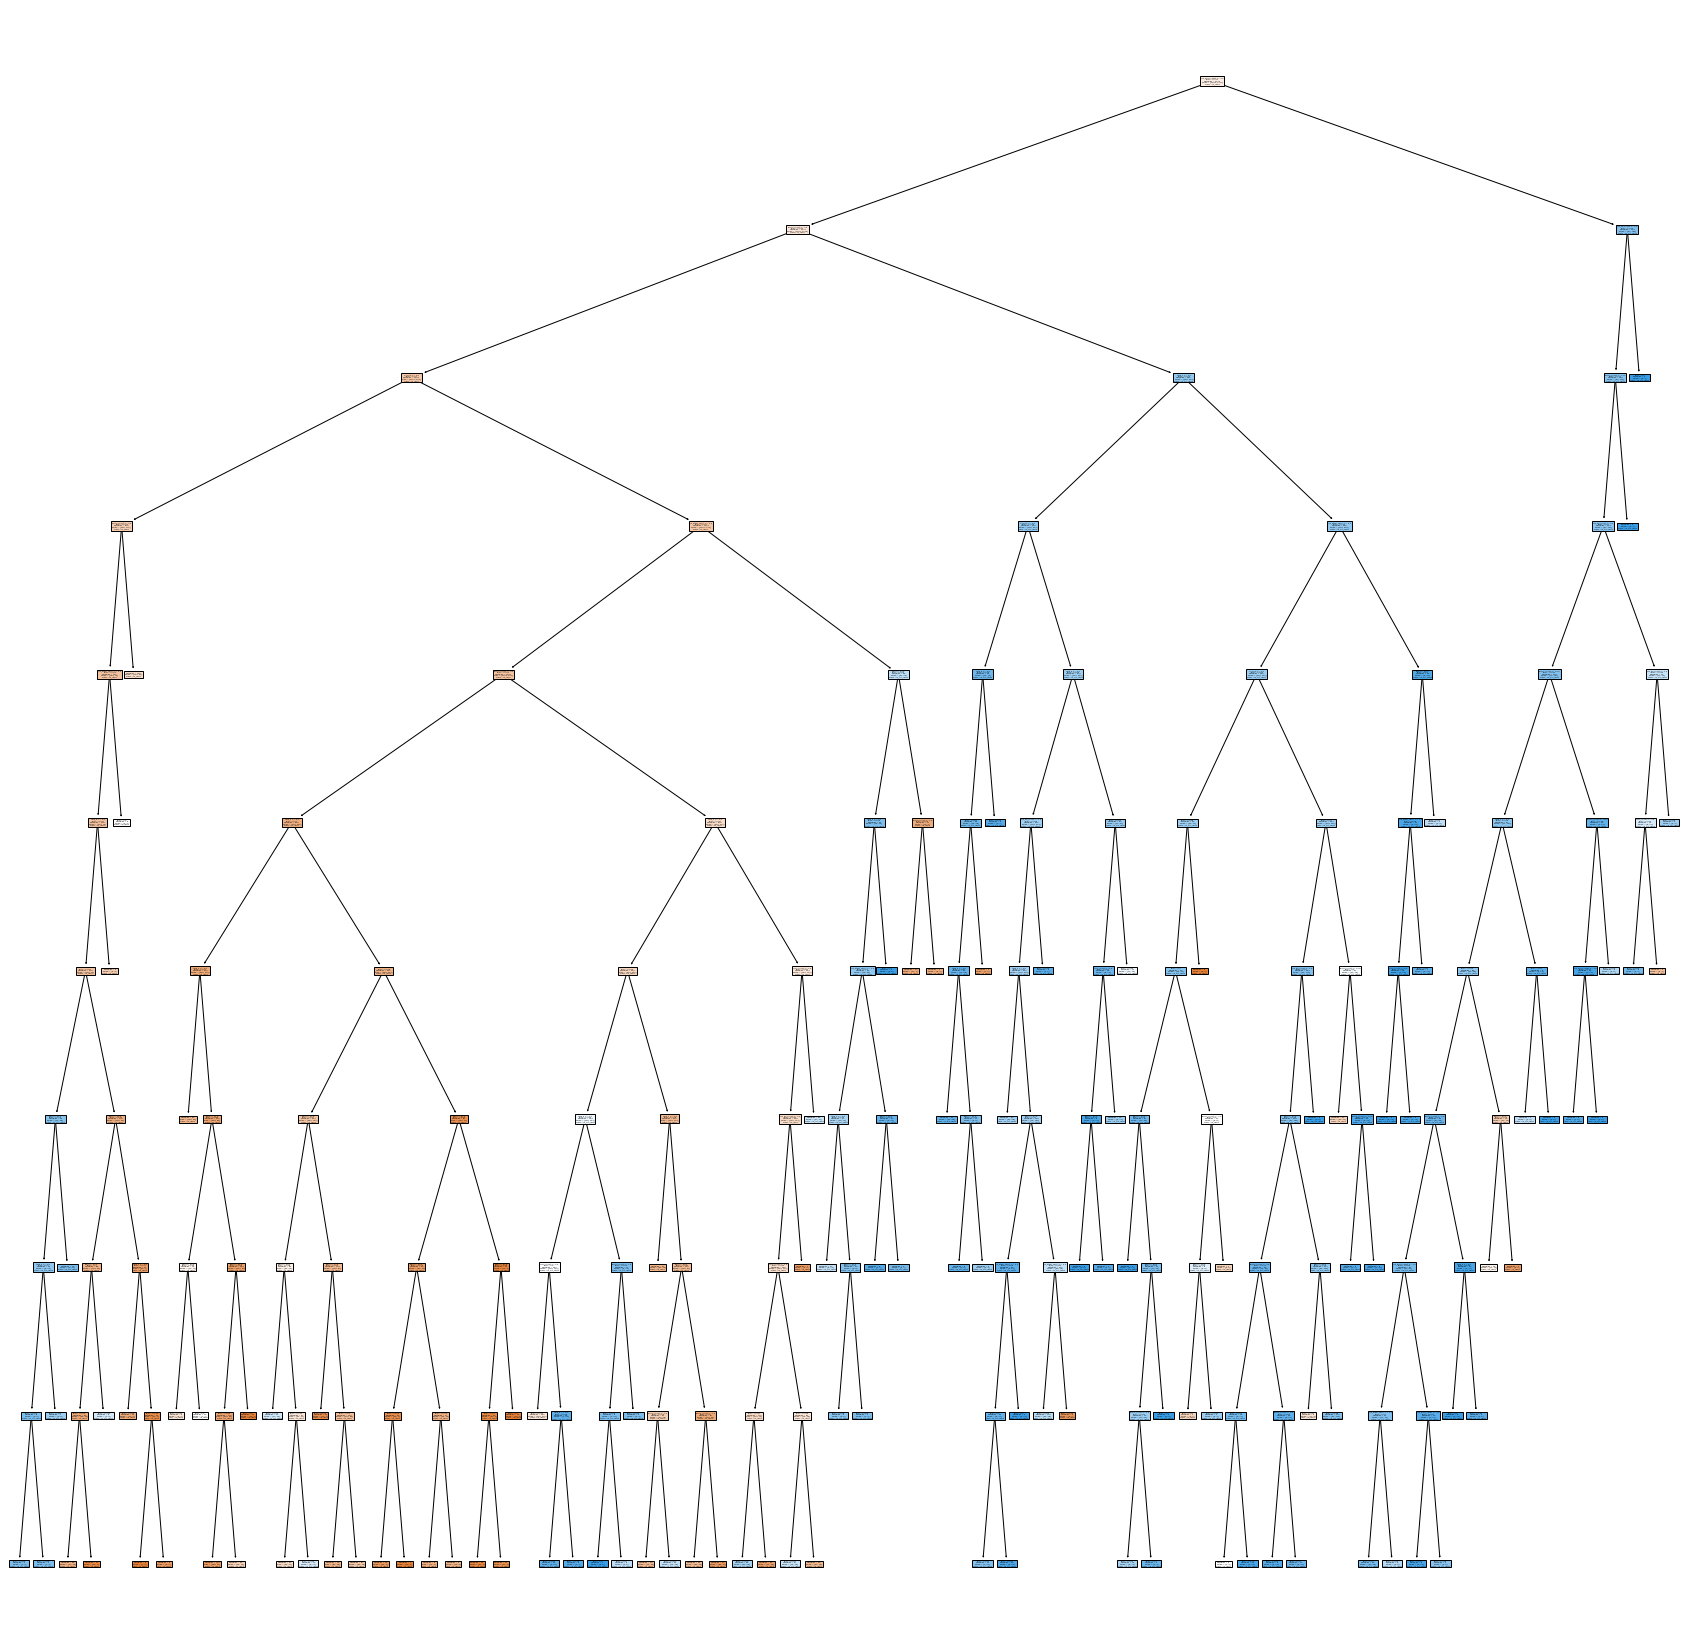

In [68]:
# Visualizing the tree
plt.figure(figsize=(30,30))
tree.plot_tree(classifier_random.best_estimator_, feature_names=list(X.columns), class_names=['is_recid', 'is_not_recid'], filled=True)

> The tree is way too complex to be easily visualized. And doesn't really tell us much, since because of the way random forest classification works. In this case a plot like this is only useful to present the inner workings of the algorithm, not to draw meaningful conclusions from it.

Before going on. Assign the predictions on the test set of your best model to the `y_hat` variable, and their related probabilities to the `y_prob` variable. Remember to use: `y_prob = model.predict_proba(X_test)`

**N.B.** Set a specific `random_state` in your model too. Otherwise if we rerun your results we might not be able to reproduce them!

In [48]:
y_hat = y_pred
y_prob = classifier_random.predict_proba(X_test)

## Part 2: Fairness and bias in Machine Learning

We already know the model you've built is biased. In the next exercises we are going to apply a debiasing method. Please, refer to Week 7, Part 3 for more hints on how to solve these exercises. But first a couple of questions about bias.

>*Exercise 2.1:* A few questions about bias.
> * What are the most common types of data bias? 
> * What are the potential bias sources/types in our case-study (i.e. recidivism)?

> *Exercise 2.2:* Equal Odds. We are going to use `y_prob` to debias the ML model for African-Americans and Caucasians.
>
>    * Define the thresholds as `ths = np.linspace(1e-5,1-1e-5, 10)` and create a function that given a threshold `th` and `y_prob` returns `y_hat` as:
>
>$$\begin{cases}\hat{y}=1, \mbox{ if } y_{prob} > th \\ \hat{y}=0, \mbox{ otherwhise}\end{cases}    \mbox(1)$$ 
>
>
>   * To find the two thresholds that correct for the bias for African-Americans and Caucasians, you can either compute the distance of the ROC curve points or visually find the thresholds (as described in Week 7 Ex. 3.3).
>      * Describe the method you have used to find the thresholds (i.e. Visual or Computational) and how you used it to identify the thresholds. What thresholds did you find? 
>   * Debias the model output by re-computing $\hat{y}$ with the thresholds you found. 
>      * **Hint 1** This means that you have to take `y_prob` of your model African-Americans and apply Eq. (1) with the threshold for African-Americans, and then repeat with the different threshold for Caucasians.
>      * **Hint 2** You shouldn't rerun your model!
>   * Now plot the confusion matrices for African-Americans and Caucasian after you debiased the method. What do you observe? What do you think the problem with this debiasing method is (Refer to Week 7 for more hints)?

## Part 2: Solution

> *Exercise 2.1*:
>   * **Response bias**: it occurs in contents generated by humans (ie. reviews, posts, articles), the source of the data is from a limited subset of the population. The majority of users represent only a few groups.
>   * **Selection bias due to feedback loops**: it occurs when a model influences the generation of data that is used to train it. The model creates this feedback loop by, for example, directing the user attention to a small subset of items then recording their action on said items for later use. This is a problem because the set of items is a non-random subset of the items.
>   * **Bias due to system drift**: it occurs when the system generating the data goes through changes as time goes on. The bias can either come in the form of concept drift (when the definiton of target changes) or model drift (changes in the way a user interacts with the system).
>   * **Omitted variable bias**: occurs when critical attributes that influence the outcome are missing. This can happen with data that was generated by humans, where they weren't allowed to record some information, or when the variable that was omitted correlated with the target or one or more predictor variables.
>   * **Societal bias**: occurs in content produced by humans. The data inherently contains bias and stereotypes and thus the models trained on these types of data will discriminate on race, gender etc.

> The types of biases that might be observable in our case-study are:
>   * **Omitted variable bias**: There might have been recorded variables omitted because they were not meant for public use. 
>   * **Societal bias**: The information on the defendants are literally produced by humans and this type of dataset discriminates highly on race and gender. We would need a way larger dataset for us to be able to come to meaningful conclusions on race and gender.

> REF5

> *Exercise 2.2*:

In [49]:
def is_above_threshold(y_prob, th):
    return [1 if val > th else 0 for val in y_prob[:, 1]]

def calc_TPR_and_FPR(y, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    if type(y) == pd.Series:
        y = list(y)

    for i in range(len(y_hat)): 
        if y[i] == y_hat[i] == 1:
           TP += 1
        if y_hat[i] == 1 and y[i] != y_hat[i]:
           FP += 1
        if y[i] == y_hat[i] == 0:
           TN += 1
        if y_hat[i] == 0 and y[i] != y_hat[i]:
           FN += 1

    return (TP / (TP+FN), FP / (FP + TN))

def roc_curve(y, y_probs, ths):
    roc = np.array([])
    
    for th in ths:
      y_hat = is_above_threshold(y_probs, th)
      TPR, FPR = calc_TPR_and_FPR(y, y_hat)
      roc = np.append(roc, [th, FPR, TPR])

    return roc.reshape(-1, 3)

ths = np.linspace(1e-5,1-1e-5, 10)

> Filtering the test attributes and labels to African-Americans and Caucasians:

In [103]:
# one-hot encoded variable race_3 is responsible for the caucasian race
ca_idx = X_test.query('race_3 == 1').index

X_test_ca = X_test.filter(items = ca_idx, axis=0)
y_test_ca = y_test.filter(items = ca_idx, axis=0)

# race_1 is the African-American race
aa_idx = X_test.query('race_1 == 1').index

X_test_aa = X_test.filter(items = aa_idx, axis=0)
y_test_aa = y_test.filter(items = aa_idx, axis=0)

> Choosing the visualization method, it should be more intuitive to choose the thresholds and spot if there were any errors while computing the rates. The receiver operating characteristic curve (or ROC) is a plot that tells us more about the characteristics of a binary classifier. To be more precise it plots the true positive rate (TPR) against the false positve rate (FPR). In our case this is useful because we can decrease the amount of society bias present in the model, by selecting a threshold where the plotted values are the closest to each other (while still taking the best TPR/FPR into account). At that threshold the model is as sensitive and produces as much fall-out to Caucasians as it does to African-Americans.

In [107]:
roc_ca = roc_curve(y_test_ca, classifier_random.predict_proba(X_test_ca), ths)
roc_aa = roc_curve(y_test_aa, classifier_random.predict_proba(X_test_aa), ths)

df_roc = pd.DataFrame(np.hstack([roc_aa, roc_ca]), columns=['TH_AA', 'FPR_AA', 'TPR_AA', 'TH_CA', 'FPR_CA', 'TPR_CA'])
cds = bp.ColumnDataSource(df_roc)

p = bp.figure(x_axis_label="FPR", y_axis_label="TPR", title="ROC Curves for Caucasian and African-American groups")

p.line('FPR_AA', 'TPR_AA', source=cds, line_width=2, line_color='lightgreen', legend_label='African-American convict')
p.line('FPR_CA', 'TPR_CA', source=cds, line_width=2, line_color='blue', legend_label='Caucasian convict')
cr_aa = p.circle('FPR_AA', 'TPR_AA', source=cds, fill_color='green', hover_fill_color='black', radius=0.01, legend_label='African-American convict')
cr_ca = p.circle('FPR_CA', 'TPR_CA', source=cds, fill_color='blue', hover_fill_color='black', radius=0.01, legend_label='Caucasian convict')

#since the thresholds are the same, we can just use one of them
p.add_tools(HoverTool(tooltips=[('Threshold', '@TH_AA')], renderers=[cr_aa, cr_ca]))
p.legend.location = 'bottom_right'
output_notebook()
bp.show(p)

Loading BokehJS ...

> The ROC curves seem to be the closest (with still good TPR and FPR values) around th = 0.444. Now we need to debias our model:

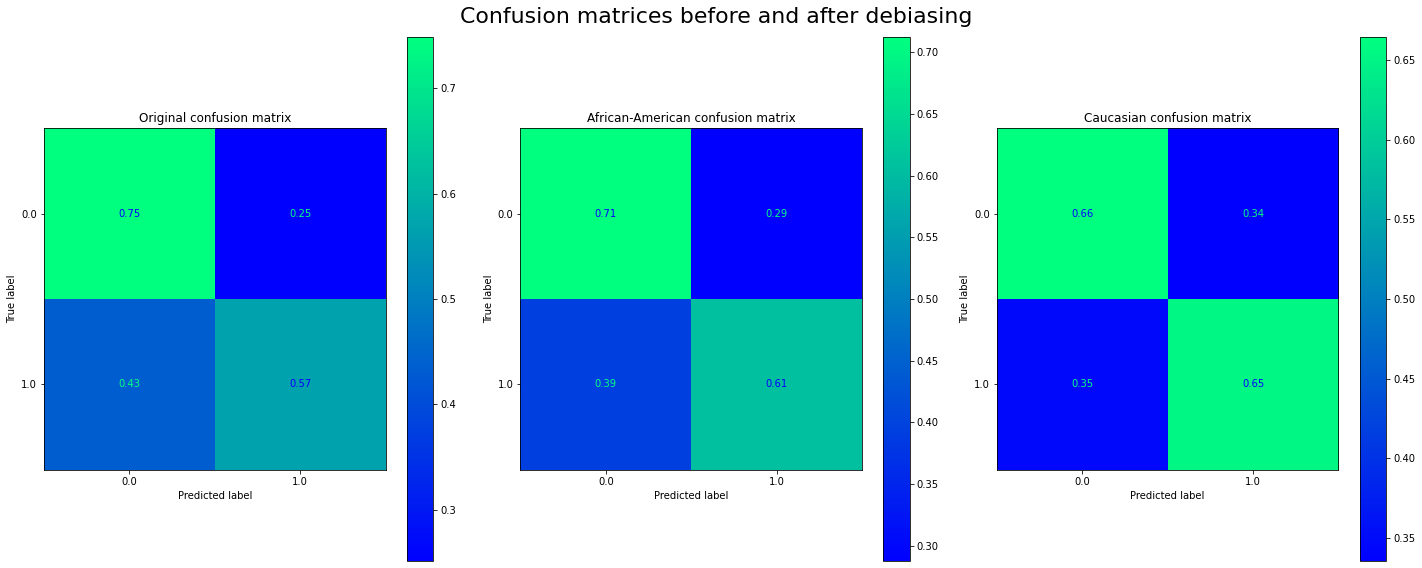

In [64]:
# debiased
y_hat_aa_th = is_above_threshold(classifier_random.predict_proba(X_test_aa), 0.444)
y_hat_ca_th = is_above_threshold(classifier_random.predict_proba(X_test_ca), 0.444)

fig, axs = plt.subplots(1,3, figsize=(20,8))
fig.suptitle('Confusion matrices before and after debiasing', fontsize=22)

ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=y_hat, normalize='true', ax=axs[0], cmap="winter")
axs[0].set_title('Original confusion matrix')
ConfusionMatrixDisplay.from_predictions(y_true=list(y_test_aa), y_pred=y_hat_aa_th, normalize='true', ax=axs[1], cmap="winter")
axs[1].set_title('African-American confusion matrix')
ConfusionMatrixDisplay.from_predictions(y_true=list(y_test_ca), y_pred=y_hat_ca_th, normalize='true', ax=axs[2], cmap="winter")
axs[2].set_title('Caucasian confusion matrix')

plt.tight_layout()
plt.show()

What we can observe is that by selecting the threshold, the absolute value of TP/TN and FP/FN came closer to on, and the model now is less likely to be biased against African-Americans.

## Part 3: Communicate your story and results to others

> *Exercise 3* Fill the article below with the title, subtitles, sections, visualizations and references!
> 
>    * **Note 1** Please, have a look at Week 8 for instructions on how to complete the article and make the visualizations.
>    * **Note 2** Make sure **you add the code** that generate your visualizations! This is really important.
>    * **Note 3** You should have all the necessary inputs to make the visualizations from the exercises in Part 1 and Part 2.

# RACIAL FACTORS WHEN PREDICTING CRIMINAL RECIDIVISM

**Introduction.** We would like to present to you an interesting issue when it comes to predicting criminal recidivism with regards to races, meaning that we would like you to take a look at what this sample data shows us, more specifically how it is biased towards Non-African-Americans. If we were to write a machine learning algorithm on this dataset, the job of which would be to tell you whether or not the defendant is likely to recommit a crime, the algorithm would be more likely to say, yes this person would recommit the crime, if he/she was an African-American. Firstly, let's take a look at the number of samples by races.

In [54]:
df = filtered
recid_idx = df.query('two_year_recid == 1').index

def n_recid(group):
    return len(group.filter(items=recid_idx))

group = 'race'
df_ = df.groupby(group).agg({group: [n_recid, 'count']}).reset_index()

df_ = df_.transpose().reset_index(level=0, drop=True).transpose()
df_.columns = [group, 'n_recid', 'count']

df_['frac_recid'] = df_['n_recid'] / df_['count']
df_['frac_tot'] = df_['n_recid'] / len(df.filter(items=recid_idx, axis=0))

df_

,race,n_recid,count,frac_recid,frac_tot
0,African-American,1661,3175,0.52315,0.591314
1,Asian,8,31,0.258065,0.002848
2,Caucasian,822,2103,0.39087,0.292631
3,Hispanic,189,509,0.371316,0.067284
4,Native American,5,11,0.454545,0.00178
5,Other,124,343,0.361516,0.044144


In [55]:
src = ColumnDataSource(df_)

tooltips = [
    ('Fraction who has recomitted a crime', '@frac_recid'),
    ('Fraction of recommitted crimes across all races', '@frac_tot')
]

p = bp.figure(plot_width=650, plot_height=450, title = f"Number of samples by {group}",
              x_axis_label=group, y_axis_label="Number of samples", x_range=df_[group], tooltips=tooltips) 

bar_cols = ['count', 'n_recid']
items = []
colors=['lightgreen', 'blue']
bar ={} 

for idx,i in enumerate(bar_cols):
    bar[i] = p.vbar(x=group,  top=i, source=src, width=0.5, color=colors[idx], muted=False)
    
    items.append((bar_cols[idx], [bar[i]]))

p.legend.visible = True
legend = Legend(items=items, location='bottom')
p.add_layout(legend, 'left')
p.legend.click_policy = "mute" #you can also try "hide"

bp.show(p)

**Results from exploratory data analysis.**
As we could see, the data is obviously biased towards Non-African-Americans they are provided in a larger sample size, there are more records where the and thus are more likely to be sentenced to jail.

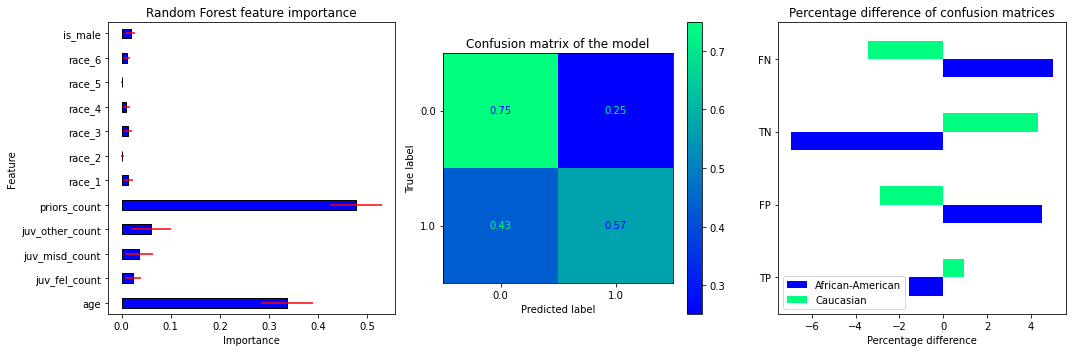

In [110]:
best_model = classifier_random.best_estimator_

forest_importances = pd.Series(best_model.feature_importances_, index=list(X_test.columns.values))

std = np.std([tree.feature_importances_ for tree in best_model.estimators_], axis=0)

CM_tot = confusion_matrix(y_test, classifier_random.predict(X_test), normalize='true').ravel()
CM_aa  = confusion_matrix(y_test_aa, classifier_random.predict(X_test_aa), normalize='true').ravel()
CM_ca = confusion_matrix(y_test_ca, classifier_random.predict(X_test_ca), normalize='true').ravel()

D_aa = (CM_aa - CM_tot) / ((CM_aa + CM_tot) / 2) * 100
D_ca = (CM_ca - CM_tot) / ((CM_ca + CM_tot) / 2) * 100

df_D = pd.DataFrame(np.vstack([D_ca,D_aa]), columns=['TP', 'FP', 'TN', 'FN'], index=['African-American', 'Caucasian'])

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

forest_importances.plot.barh(xerr=std, ax=axs[0], width=0.4, ecolor='red', edgecolor='black', cmap="winter")
axs[0].set(title="Random Forest feature importance",ylabel="Feature",xlabel='Importance')

ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=classifier_random.predict(X_test), normalize='true', ax=axs[1], cmap="winter")
axs[1].set(title='Confusion matrix of the model')

df_D.T.plot.barh(ax=axs[2], cmap="winter")
axs[2].set(title='Percentage difference of confusion matrices', xlabel='Percentage difference')

plt.tight_layout()
plt.show()

Racial stereotypes have long been a major issue for society and there has been many research trying to debunk the myth behind what is the biggest reason that we cannot get rid of them completely. The biggest reason for their existence is that people and especially children are more likely to see/hear news which involve a certain type of race because of an inherited bias in their environment. This bias from the parents for example can easily be forwarded to their children and so on. Machine learning can in a way be looked at feeding information to a child and letting it build it's own way of seeing the world. If the information that we give is biased the model will inevitably become biased as well. The dataset in question is a good example for this, as you can see on the diagrams there is a higher general sample count for african-americans than any other race. This is already a problem as the dataset is imbalanced. Even more so based on the dataset the recession rate of african americans is way higher than for example caucasians and there are more prior crimes recorded as well, which based on our model is one of the main influence factors for later recession. We decided to fix this problem the exact same way as you could alter your childs view on life. We tried to change the threshold of our model so that it would have an equal crime prediction rate for both races. In case of children this is like teaching them after how many bad actions should they consider a person bad and which actions are bad in general. We looked at a so called ROC curve for both caucasian and african american predictions and tried to find a threshold where the prediction rates are similar. After finding and applying this threshold to our model and changing it's view on how bad of a person should be considered a potential recessive criminal we managed to improve the biased nature of our model. The improvement was definitely noticable however not too impressive and just shows how much of an influence a base information is for a fresh developing mind. Closing the story with the same metaphore you can try to manually change the view of someone but if they keep getting fed biased or straight up false information they will inevitably build their worlds around that and it will take a lot of new experience and influence for them to change their already developed point of views.

**References.**

1. https://www.analyticsvidhya.com/blog/2020/03/one-hot-encoding-vs-label-encoding-using-scikit-learn/
2. https://williamkoehrsen.medium.com/random-forest-simple-explanation-377895a60d2d
3. https://towardsdatascience.com/how-are-decision-trees-built-a8e5af57ce8
4. https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
5. https://www.youtube.com/watch?v=tcz800ZXclA

**Assignment Contributions**:

* ST126: Entirity of Part1 and coding for Part2
* ST123: Visualizations of Part2&3
* ST151: Writing the story of Part3 and helping with the visualizations